In [1491]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [1492]:
# Config
pattern_size = (18, 14) # width, height
s = 1
image_size = (480 // s, 640 // s)
border_width = 40 // s
square_size = 25 // s

In [1493]:
# Generate chessboard pattern
pattern_image = np.ones(image_size, np.float32)
pattern_corners = np.zeros(((pattern_size[0]) * (pattern_size[1]), 2), np.float32)
n = 0
for j in range(pattern_size[1] + 1):
    y = border_width + j * square_size
    for i in range(pattern_size[0] + 1):
        x = border_width + i * square_size

        if (i + j) % 2 == 0:
            pattern_image[y:y + square_size, x:x + square_size] = 0

        if 0 < i <= pattern_size[0] and 0 < j <= pattern_size[1]:
            pattern_corners[n, 0] = x - 0.5
            pattern_corners[n, 1] = y - 0.5
            n += 1


In [1494]:
# Modified version from SO
def noisy(noise_typ, image):
    if noise_typ == "gauss":
        row, col = image.shape
        mean = 0
        var = 0.00001
        sigma = 1/255 #var ** 0.5
        gauss = np.random.normal(mean, sigma, (row, col))
        gauss = gauss.reshape(row, col)
        noisy = image + gauss
        noisy[noisy < 0] = 0
        return noisy
    elif noise_typ == "s&p":
        row, col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image.shape]
        out[coords] = 0
        return out

    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ == "speckle":
        row, col = image.shape
        gauss = np.random.randn(row, col)
        gauss = gauss.reshape(row, col)
        noisy = image + image * gauss
    return noisy

In [1495]:
#pattern_image = noisy('gauss', pattern_image)

In [1496]:
# Convert to uint8
pattern_image = (255 * pattern_image).astype(np.uint8)

In [1497]:

# Add perspective distortion
h = image_size[0]
w = image_size[1]
dy = image_size[0] / 4
dx = image_size[1] / 4
p1 = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
p2 = np.array([[0, 0], [w - dx, dy], [w - dx, h - dy], [0, h]], dtype=np.float32)
W = cv.getPerspectiveTransform(p1, p2)

pattern_image = cv.warpPerspective(pattern_image, W, [w, h])

pattern_corners = cv.perspectiveTransform(pattern_corners[None, :, :], W)
pattern_corners = pattern_corners[0, :, :]

In [1498]:
# Add blur
# pattern_image = cv.GaussianBlur(pattern_image, (7, 7), 0)

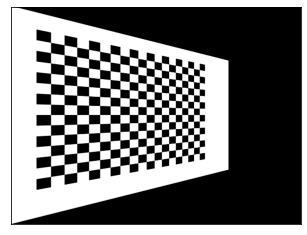

In [1499]:
# Show target image
plt.imshow(pattern_image, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()


In [1500]:
# Find corners
status, corners = cv.findChessboardCorners(pattern_image, pattern_size)
if status:
    #print(corners)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_COUNT, 300, 0.01)
    cv.cornerSubPix(pattern_image, corners, (5, 5), (-1, -1), criteria)
else:
    print("Could not detect corners")

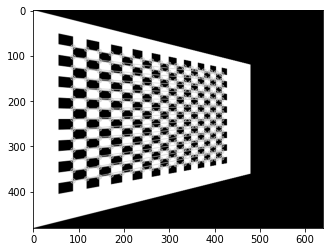

In [1501]:
# Show found corners
cv.drawChessboardCorners(pattern_image, pattern_size, corners, status)
plt.imshow(pattern_image, cmap='gray')
plt.show()

In [1502]:
# Calculate diff
corners = corners.reshape(-1, 2)
print(corners.shape)
print(pattern_corners.shape)

diff = corners - pattern_corners
#print(np.mean(diff, axis=1))


(252, 2)
(252, 2)


0.15650582


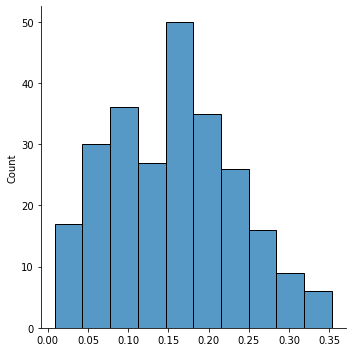

In [1503]:
# Calculate and show errors distribution
errors = np.linalg.norm(diff, axis=1)
sns.displot(errors)
print(np.mean(errors))